In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv("fake_job_postings.csv")
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data.isnull()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,True,True,False,False,False,True,False,False,False,True,True,True,True,True,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
17876,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
17877,False,False,False,True,True,False,False,False,True,False,False,False,False,True,True,True,True,False
17878,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False


In [6]:
data.dropna(subset=['location'], inplace=True)
data.dropna(subset=['description'], inplace=True)
mode_department = data['department'].mode()[0]
data['department'].fillna(mode_department, inplace=True)

data['salary_range'].fillna(0, inplace=True)
data['company_profile'].fillna(0, inplace=True)
data['requirements'].fillna(0, inplace=True)
data['benefits'].fillna(0, inplace=True)
data['employment_type'].fillna(0, inplace=True)
data['required_experience'].fillna(0, inplace=True)
data['required_education'].fillna(0, inplace=True)
data['industry'].fillna(0, inplace=True)
data['function'].fillna(0, inplace=True)


In [7]:
data.isnull().sum()


job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

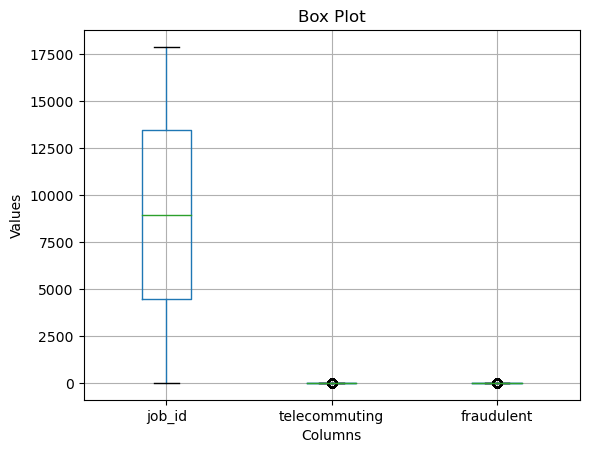

In [8]:
columns_to_plot = ['job_id', 'telecommuting','fraudulent']

data[columns_to_plot].boxplot()

plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plot')

plt.show()


In [9]:
data.shape

(17533, 18)

In [10]:
data.telecommuting.value_counts()

0    16787
1      746
Name: telecommuting, dtype: int64

In [11]:
data.department.value_counts()

Sales                         11798
Engineering                     486
Marketing                       396
Operations                      270
IT                              221
                              ...  
Greetsnap Development             1
Customer Service Rep.             1
I9 Manufacturing (345)            1
Organisational Development        1
Hospitality                       1
Name: department, Length: 1326, dtype: int64

In [12]:
data.required_experience.value_counts()

0                   6796
Mid-Senior level    3776
Entry level         2685
Associate           2282
Not Applicable      1100
Director             386
Internship           368
Executive            140
Name: required_experience, dtype: int64

In [13]:
data.required_education.value_counts()

0                                    7820
Bachelor's Degree                    5112
High School or equivalent            2067
Unspecified                          1392
Master's Degree                       410
Associate Degree                      272
Certification                         169
Some College Coursework Completed     101
Professional                           74
Vocational                             48
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In [14]:
data.salary_range.value_counts()

0                14687
0-0                141
40000-50000         66
30000-40000         55
45000-67000         37
                 ...  
300000-325000        1
27500-36000          1
20-22                1
110-120              1
3700-3800            1
Name: salary_range, Length: 868, dtype: int64

In [15]:
data.industry.value_counts()

0                                      4654
Information Technology and Services    1718
Computer Software                      1364
Internet                               1048
Education Management                    822
                                       ... 
Museums and Institutions                  1
Wine and Spirits                          1
Shipbuilding                              1
Alternative Dispute Resolution            1
Ranching                                  1
Name: industry, Length: 132, dtype: int64

In [16]:
data.function.value_counts()

0                         6192
Information Technology    1735
Sales                     1458
Engineering               1335
Customer Service          1227
Marketing                  821
Administrative             620
Health Care Provider       337
Design                     336
Education                  325
Other                      323
Management                 317
Business Development       226
Accounting/Auditing        212
Human Resources            204
Project Management         183
Finance                    171
Consulting                 143
Art/Creative               131
Writing/Editing            129
Production                 115
Product Management         114
Quality Assurance          110
Advertising                 88
Business Analyst            82
Data Analyst                81
Public Relations            76
Manufacturing               74
General Business            65
Research                    50
Legal                       47
Strategy/Planning           46
Training

In [17]:
data.isnull()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17876,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17877,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17878,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [18]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17533.000000,17533.000000,17533.000000,17533.000000,17533.000000
mean,8944.893857,0.042548,0.794445,0.491644,0.048252
std,5172.938368,0.201842,0.404118,0.499944,0.214304
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4453.000000,0.000000,1.000000,0.000000,0.000000
50%,8950.000000,0.000000,1.000000,0.000000,0.000000
75%,13434.000000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
data['company_profile'] = data['company_profile'].astype(str)

In [20]:
data['salary_range'] = data['salary_range'].astype(str)

In [21]:
data.head(20)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,0,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,0,1,0,Other,Internship,0,0,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,0,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,0,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Sales,0,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,0,1,0,0,0,0,0,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,0,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",Sales,0,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",Sales,0,0,Job OverviewApex is an environmental consultin...,0,0,0,0,0,0,0,0,0,0,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",Sales,0,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,0,0,0,0,0,0
8,9,HP BSM SME,"US, FL, Pensacola",Sales,0,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,0,0,1,1,Full-time,Associate,0,Information Technology and Services,0,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",Sales,0,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,0,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [22]:
data['title'].unique()

array(['Marketing Intern', 'Customer Service - Cloud Video Production',
       'Commissioning Machinery Assistant (CMA)', ...,
       'Senior Financial Analyst (Retail) ',
       'Account Director - Distribution ',
       'Project Cost Control Staff Engineer - Cost Control Exp - TX'],
      dtype=object)

In [23]:
data['location'].unique()

array(['US, NY, New York', 'NZ, , Auckland', 'US, IA, Wever', ...,
       'US, CA, los Angeles', 'CA, , Ottawa', 'GB, WSX, Chichester'],
      dtype=object)

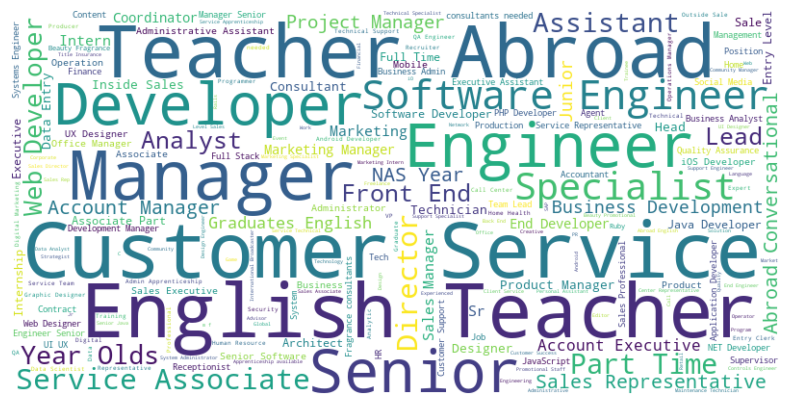

In [24]:
text = " ".join(title for title in data.title)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()


In [25]:
# fraudulent jobs
data['fraudulent'].unique()

array([0, 1], dtype=int64)

In [26]:
#fraudulent & non fraudulent
data_f = data[data['fraudulent'] == 1]  #fraudulent
data_nf = data[data['fraudulent'] == 0]  # non fraudulent

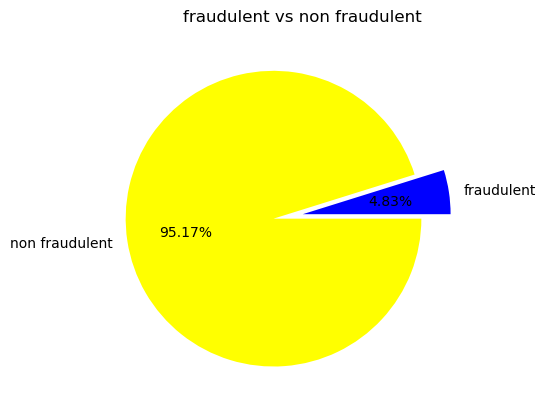

In [27]:
plt.title('fraudulent vs non fraudulent')
plt.pie([data_f.shape[0], data_nf.shape[0]], 
        labels=['fraudulent', 'non fraudulent'], 
        explode=(0, 0.2),
        autopct='%1.2f%%',
       colors=['blue','yellow'])
plt.show()


In [28]:
#fraudulent is 4.83%
#non fraudulent is 95.17%

In [29]:
us_jobs = data[data['location'] == 'US']

common_titles = us_jobs['title'].value_counts()

most_common_title = common_titles.idxmax()
most_common_title


'Customer Service Associate '

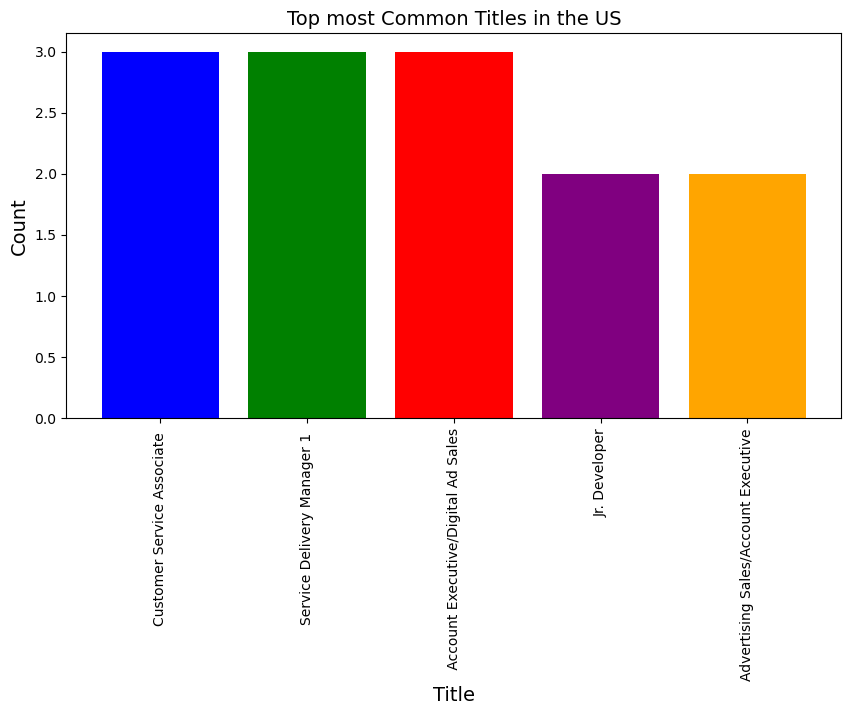

In [30]:
top_5_titles = common_titles.head(5)

plt.figure(figsize=(10, 5))
plt.bar(top_5_titles.index, top_5_titles, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title("Top most Common Titles in the US", fontsize=14)
plt.xlabel("Title", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=90)
plt.show()


In [31]:
#The most common title used in jobs in the US
#Customer Service Associate


In [32]:
fake_jobs = data[data['fraudulent'] == 1]
department_counts = fake_jobs['department'].value_counts()
most_fake_jobs_department = department_counts.idxmax()
most_fake_jobs_department


'Sales'

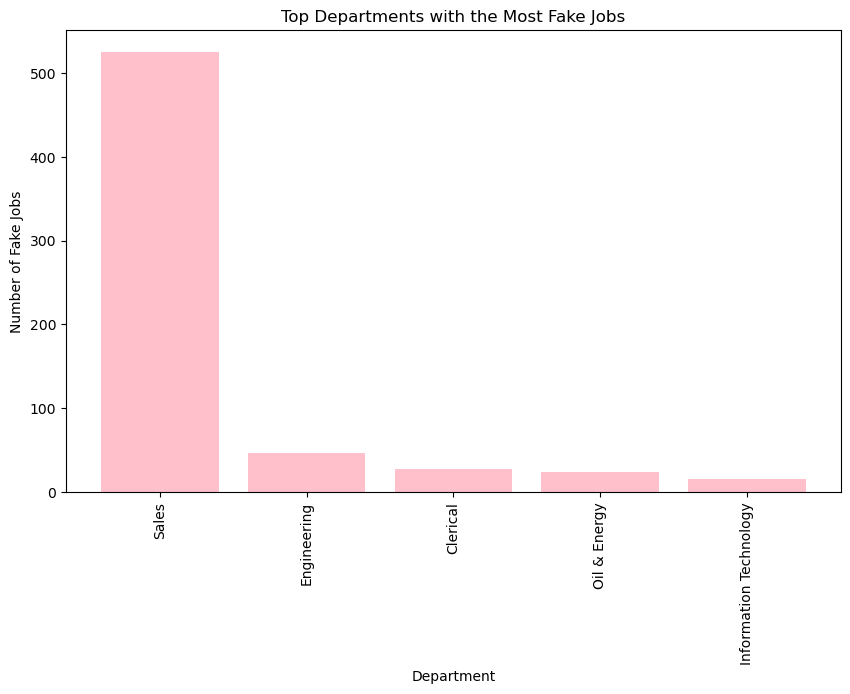

In [33]:
top_departments = department_counts.head(5)
plt.figure(figsize=(10, 6))
plt.bar(top_departments.index, top_departments.values,color='pink')
plt.xlabel('Department')
plt.ylabel('Number of Fake Jobs')
plt.title('Top Departments with the Most Fake Jobs')
plt.xticks(rotation=90)
plt.show()

In [34]:
# Department that has the most number of fake jobs
#Sales

In [35]:
salary_range = data['salary_range']
highest_range_value = 0
highest_range_row = None

pattern = r'(\d+)-(\d+)'

for i, range_str in enumerate(salary_range):
    match = re.match(pattern, range_str)
    if match:
        upper = int(match.group(2))
        
        if upper > highest_range_value:
            highest_range_value = upper
            highest_range_row = data.iloc[i]

print(f"The highest salary range value is {highest_range_value}")
print(f"The complete row with highest range value is:")
print(highest_range_row)


The highest salary range value is 1200000000
The complete row with highest range value is:
job_id                                                              3140
title                                             National Sales Manager
location                                                 ID, JW, Jakarta
department                                          Danone - Sari Husada
salary_range                                        800000000-1200000000
company_profile        Local expertise with an international perspect...
description            Sari Husada is a member of a leading food and ...
requirements           The candidates will required to have a univers...
benefits                                                         .../...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          0
employment_type                  

In [36]:
salary_range = data['salary_range']
departments = data['department']
locations = data['location']  
highest_range_department = None

pattern = r'(\d+)-(\d+)'

for i, (range_str, department, location) in enumerate(zip(salary_range, departments, locations)):
    if location == 'GB':
        match = re.match(pattern, range_str)
        if match:
            upper = int(match.group(2))
            
            if upper > highest_range_value:
                highest_range_value = upper
                highest_range_department = department
                highest_range_row = data.iloc[i]

print(f"The highest salary range value in the UK is {highest_range_value}")
print(f"The department with the highest range value in the UK is: {highest_range_department}")
print(highest_range_row)


The highest salary range value in the UK is 1200000000
The department with the highest range value in the UK is: None
job_id                                                              3140
title                                             National Sales Manager
location                                                 ID, JW, Jakarta
department                                          Danone - Sari Husada
salary_range                                        800000000-1200000000
company_profile        Local expertise with an international perspect...
description            Sari Husada is a member of a leading food and ...
requirements           The candidates will required to have a univers...
benefits                                                         .../...
telecommuting                                                          0
has_company_logo                                                       1
has_questions                                                          0
employ

In [37]:
#Highest salary range in UK(GB) of department "Danone - Sari Husada" and function "Sales"

In [38]:
#Highest salary range is 800000000-1200000000
#Highest salary range in UK(GB) is 65000

In [39]:
company_profiles = data['company_profile'].str.lower().str.split()

words = [word for sublist in company_profiles for word in sublist]

counter = Counter(words)
top_words = counter.most_common(3)

print(top_words)


[('and', 77936), ('the', 60110), ('to', 47239)]


In [40]:
company_profiles = data['company_profile'].str.lower().str.replace('[^\w\s]', '', regex=True)

stop_words = set(stopwords.words('english'))
word_list = [word for description in company_profiles for word in word_tokenize(description) if word not in stop_words]

word_counts = Counter(word_list)

top_words = word_counts.most_common(3)

print(top_words)


[('team', 6934), ('work', 6821), ('services', 6593)]


In [41]:
#What are the top 3 most commonly used words in Company Profile? (Excluding stopwords)
#Answer=['team','work','services']

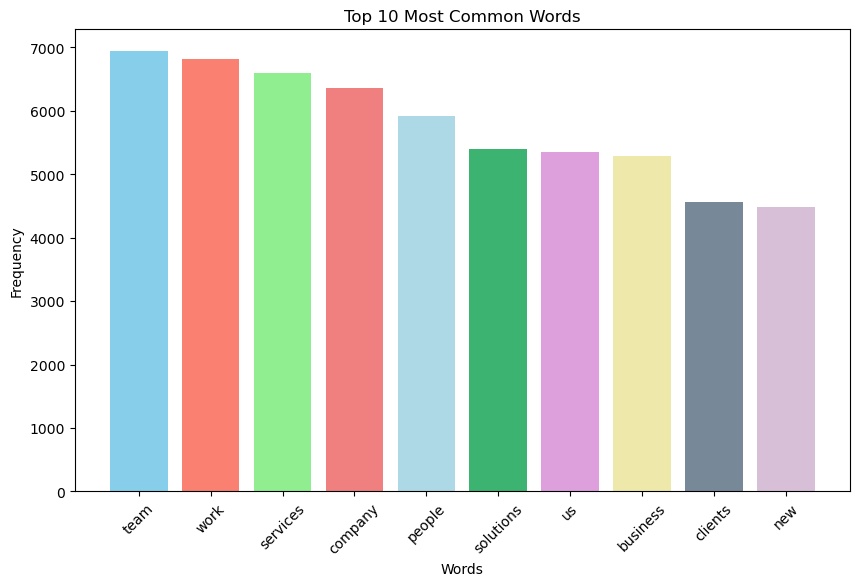

In [42]:
top_10_words = word_counts.most_common(10)

words, counts = zip(*top_10_words)

colors = ['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'lightblue', 'mediumseagreen', 'plum', 'palegoldenrod', 'lightslategray', 'thistle']

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color=colors)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.xticks(rotation=45)

plt.show()


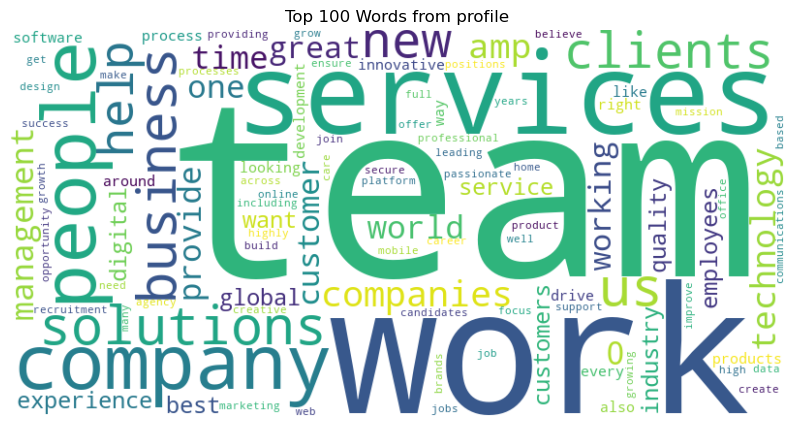

In [43]:
top_100_words = word_counts.most_common(100)

wordcloud_dict = {word: count for word, count in top_100_words}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Words from profile')
plt.show()


In [44]:
#logistic_regression

In [45]:
X = data[['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']]
y = data['fraudulent']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [47]:
y_pred = model.predict(X_test)


In [48]:
accuracy_LR = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [49]:
print(accuracy_LR)
print(report)

0.951240376390077
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3324
           1       0.80      0.09      0.16       183

    accuracy                           0.95      3507
   macro avg       0.88      0.54      0.57      3507
weighted avg       0.94      0.95      0.93      3507



In [50]:
# k-Nearest Neighbors 

In [51]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values of 'n_neighbors'
knn_classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [52]:
y_pred = knn_classifier.predict(X_test)

In [53]:
accuracy_KNN = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [54]:
print(accuracy_KNN)
print(report)

0.9674935842600513
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3324
           1       0.83      0.48      0.60       183

    accuracy                           0.97      3507
   macro avg       0.90      0.73      0.79      3507
weighted avg       0.96      0.97      0.96      3507



In [55]:
#Random Forest Classifier algorithm

In [56]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [57]:
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

In [58]:
accuracy_RFC = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

In [59]:
print(accuracy_RFC)
print(report)

0.9823210721414314
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3324
           1       1.00      0.66      0.80       183

    accuracy                           0.98      3507
   macro avg       0.99      0.83      0.89      3507
weighted avg       0.98      0.98      0.98      3507



In [60]:
#Random Forest classifier has the higest accuracy of 0.98

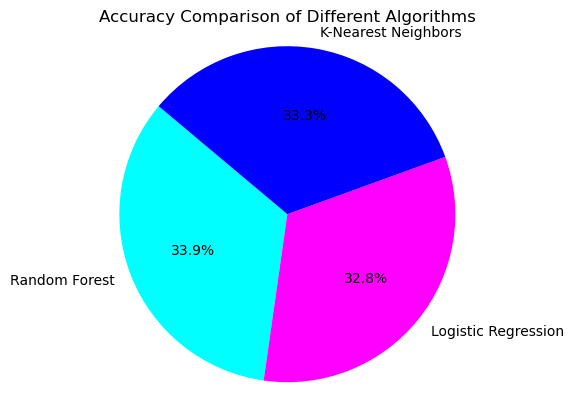

In [69]:
import matplotlib.pyplot as plt

# List of algorithm names
algorithms = [
    'Random Forest',
    'Logistic Regression',
    'K-Nearest Neighbors']

# List of corresponding accuracy scores
accuracy_scores = [accuracy_RFC,accuracy_LR, accuracy_KNN]

# Define unique colors
colors = ['Cyan', 'Magenta', 'Blue']

# Create a pie chart
plt.pie(accuracy_scores, labels=algorithms, colors=colors, autopct='%1.1f%%', startangle=140)

# Add title
plt.title('Accuracy Comparison of Different Algorithms')

# Display the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [61]:
#Metrix Calculation

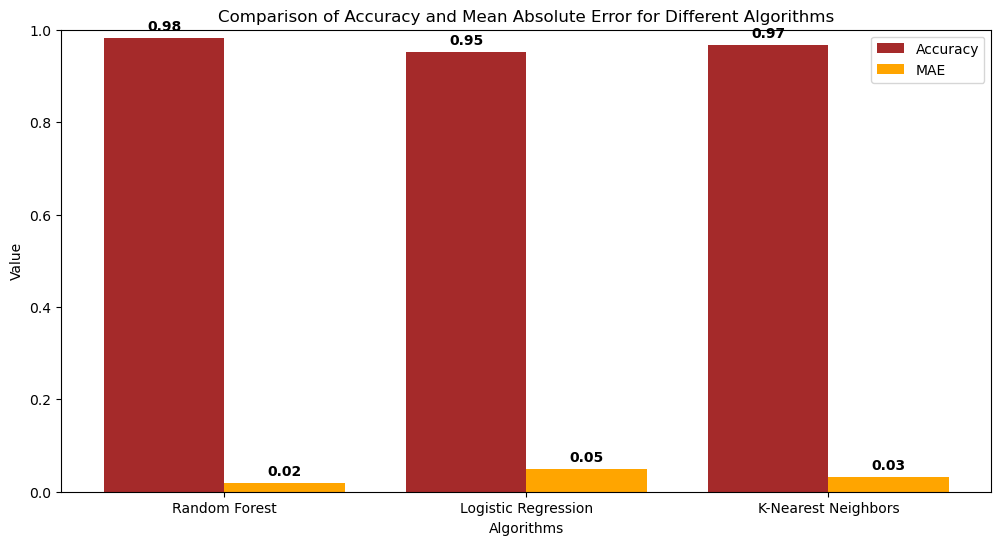

In [62]:


# Define the models
models =[
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5))]

accuracies = []
mae_values = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append((name, accuracy))
    mae = mean_absolute_error(y_test, y_pred)
    mae_values.append((name, mae))

plt.figure(figsize=(12, 6))

plt.bar([i for i, _ in enumerate(models)], [acc for _, acc in accuracies], width=0.4, color='brown', align='center', label='Accuracy')

plt.bar([i + 0.4 for i, _ in enumerate(models)], [mae for _, mae in mae_values], width=0.4, color='orange', align='center', label='MAE')

plt.xlabel('Algorithms')
plt.ylabel('Value')
plt.title('Metrix calculation')
plt.xticks([i + 0.2 for i, _ in enumerate(models)], [name for name, _ in models])
plt.ylim(0, 1)
plt.legend()

for i, (_, acc) in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold', fontsize=10)

for i, (_, mae) in enumerate(mae_values):
    plt.text(i + 0.4, mae + 0.01, f'{mae:.2f}', ha='center', va='bottom', color='black', fontweight='bold', fontsize=10)

plt.show()


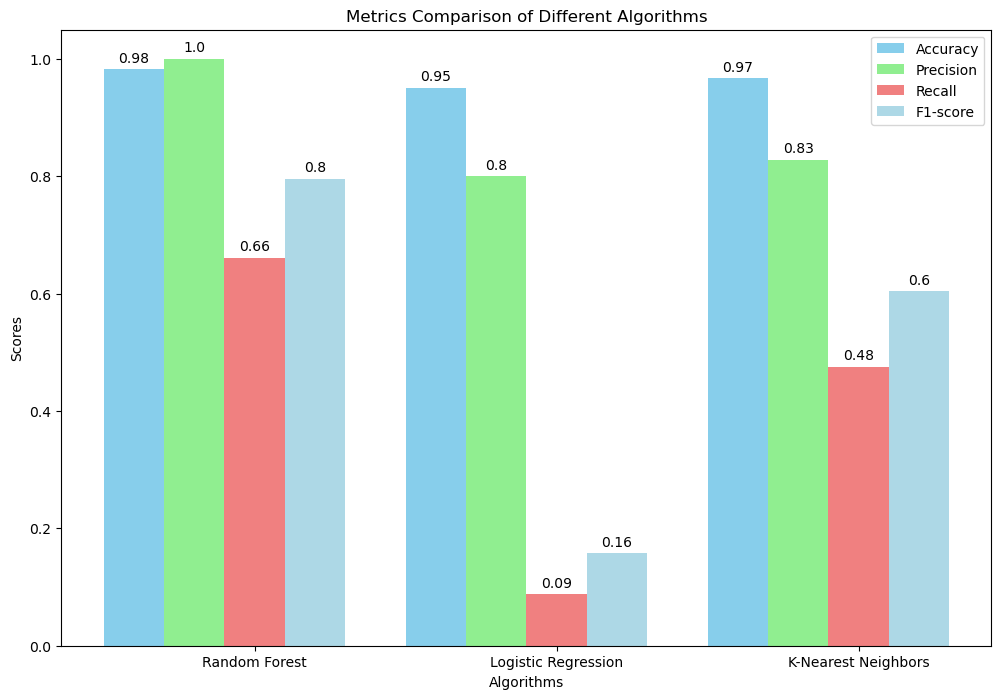

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# List of algorithm names
algorithms = ['Random Forest', 'Logistic Regression', 'K-Nearest Neighbors']

# List of corresponding metric scores
accuracy_scores = [accuracy_rf, accuracy_lr, accuracy_knn]
precision_scores = [precision_rf, precision_lr, precision_knn]
recall_scores = [recall_rf, recall_lr, recall_knn]
f1_scores = [f1_rf, f1_lr, f1_knn]

# Define the positions for the bars
x = np.arange(len(algorithms))

# Define the width of the bars
width = 0.2

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bars for each metric
rects1 = ax.bar(x - width, accuracy_scores, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x, precision_scores, width, label='Precision', color='lightgreen')
rects3 = ax.bar(x + width, recall_scores, width, label='Recall', color='lightcoral')
rects4 = ax.bar(x + 2*width, f1_scores, width, label='F1-score', color='lightblue')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Algorithms')
ax.set_ylabel('Scores')
ax.set_title('Metrics Comparison of Algorithms')
ax.set_xticks(x + width)
ax.set_xticklabels(algorithms)
ax.legend()

# Add labels for each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()
